# This code is to extimate the position of Willapa Bay shorleline before 1860

In [1]:
import sympy as sy
import sympy.geometry as gm

In [2]:
import geopy

In [3]:
import rasterio

In [4]:
from osgeo import gdal

In [5]:
import sys

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import math

In [9]:
from osgeo import gdal

In [47]:
from shapely.geometry import Point, Polygon, LineString, MultiLineString,MultiPoint,MultiPolygon

In [72]:
import pandas as pd

In [120]:
import os

In [26]:
#create a dictionary, and then save each gdf as a value in the dictionary
gdf_dict = {}
for year in range(1700, 1912):
    gdf_dict[f"shoreline_{year}"] = gpd.read_file(f"../assets/ECY_estimated_shorelines/Aug4/{year}.geojson")


In [27]:

for year in range(1912,1926):
    gdf_dict[f"shoreline_{year}"] = gpd.read_file(f"../assets/ECY_estimated_shorelines/Aug21/{year}.geojson")

## Open the shapefile of the shoreline in 1860

In [7]:
coast_1860=gpd.read_file("../assets/ECY_estimated_shorelines/Aug4/1860.geojson")
coast_1860

,Shape_Leng,layer,geometry
0,0.181588,layer1,"MULTILINESTRING ((-124.11763 46.87711, -124.11..."
1,NaN,layer2,"LINESTRING (-124.11763 46.87711, -124.11250 46..."


In [16]:
#open the shapefile of 1911 shoreline
coast_1911=gpd.read_file("../assets/ECY_estimated_shorelines/Aug4/1911.geojson")

In [13]:
import contextily as ctx

In [60]:
#function to plot the shoreline

def line_show(gdf):
    gdf = gdf.to_crs(epsg=3857)

    # assuming gdf1 and gdf2 are your GeoDataFrames
    fig, ax = plt.subplots(figsize = (10,10))

    coast_1911_3857 = coast_1911.to_crs(epsg=3857)

    # plot the base map of 1911
    base = coast_1911_3857.plot(ax=ax, color='white', edgecolor='black')

    # plot the first GeoDataFrame

    gdf.plot(ax=base, marker='o', color='black', markersize=5)

    ctx.add_basemap(ax,zoom=11,source=ctx.providers.CartoDB.Positron)

    # Show the plot
    plt.show()

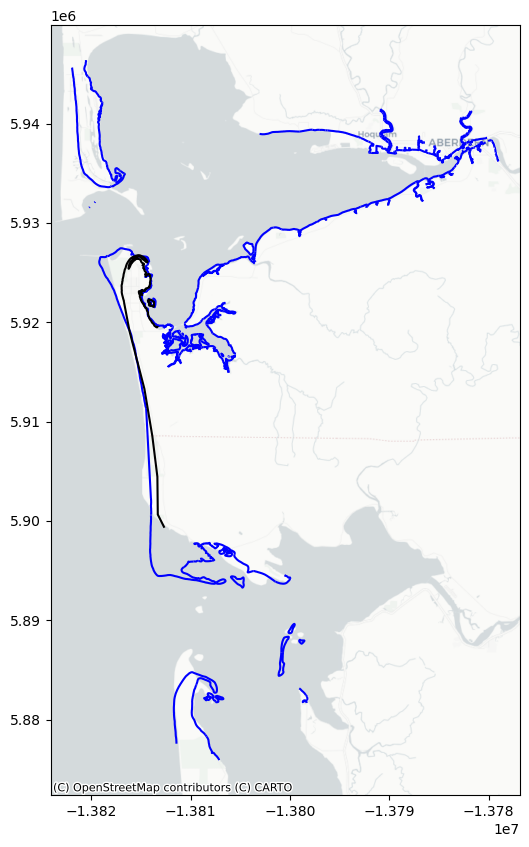

In [22]:
line_show(coast_1860)

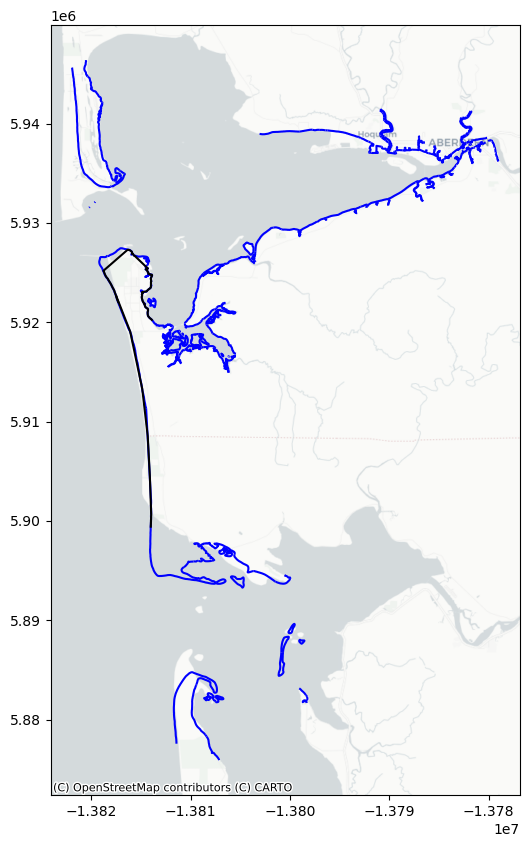

In [38]:
line_show(gdf_dict["shoreline_1910"])

In [39]:
#find the southernmost point of the 1700 shoreline
coast_1700=gdf_dict["shoreline_1700"]
coast_1700


,layer,geometry
0,layer1,"MULTILINESTRING ((-124.11697 46.88119, -124.11..."
1,layer3,"MULTILINESTRING ((-124.11588 46.87739, -124.11..."


In [57]:
#function to find the southernmost point of a shoreline, gdf is a geodataframe
def find_south_point(gdf):
    south_point=None
    south_candidate = 90
    
    for geometry in gdf.geometry:
        if isinstance(geometry, MultiLineString):
            for linestring in geometry.geoms:
                for point in linestring.coords:
                    lat_candidate = point[1]
                    if lat_candidate < south_candidate:
                        south_candidate = lat_candidate
                        south_point = point
        elif isinstance(geometry, LineString):
            for point in geometry.coords:
                lat_candidate = point[1]
                if lat_candidate < south_candidate:
                    south_candidate = lat_candidate
                    south_point = point
        else:
            raise TypeError('Geometry must be a LineString or MultiLineString')
    return south_point

In [80]:
find_south_point(coast_1700)

(-124.079244, 46.737395)

In [79]:
find_south_point(coast_1700)[0]

-124.079244

In [48]:
#function to clip the gdf
def clip(polygon_list,gdf_for_clipping):
    polygon=Polygon(polygon_list)
    gdf_after_clipping = gdf_for_clipping.clip(polygon)
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_1911.crs)
    return gdf_after_clipping


In [ ]:

    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_1911_clipped.plot(ax=ax, color="purple")
    poly_gdf.boundary.plot(ax=ax, color="black")

In [50]:
#this is the function to keep features that are out of the clipping polygon
def gdf_not_clipped(geometry,polygon_list):
    polygon=Polygon(polygon_list)
    if geometry.intersects(polygon):  # If the geometry intersects the polygon
        return geometry.difference(polygon) # Return the part of the geometry outside the polygon
    elif not polygon.contains(geometry):  # If the geometry is completely outside the polygon
        return geometry
    else:
        return None # Return None if the geometry is completely inside the polygon


In [54]:
#this cell is to get the boundary of the clipping polygon of 1911
lat_up_left=46.733252766225945
lon_up_left=-124.079244
lat_down_right=46.69
lon_down_right=-123.8

poly_list_1911=[(lon_up_left,lat_up_left),(lon_down_right,lat_up_left),(lon_down_right,lat_down_right),(lon_up_left,lat_down_right)]


In [127]:
#to get the clipped gdf of 1911 shoreline

not_clipped_1911 = gdf_dict["shoreline_1911"]['geometry'].apply(gdf_not_clipped,args=(poly_list_1911,))

clipped_1911=clip(poly_list_1911,gdf_dict["shoreline_1911"])

clipped_1911



/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,layer,geometry
672,950614.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.03416 46.70315, -124.03416 46..."
664,949599.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.01947 46.70556, -124.01969 46..."
684,949594.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.03416 46.70323, -124.03415 46..."
691,950617.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"LINESTRING (-124.00076 46.71047, -124.00009 46..."
682,949589.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.01754 46.72099, -124.01760 46..."
649,950602.0,15.0,T03224,P,19110101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"LINESTRING (-124.06344 46.71292, -124.06315 46..."
692,950618.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"LINESTRING (-124.05478 46.71648, -124.05466 46..."
654,950619.0,15.0,T03224,P,19110101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"LINESTRING (-124.05466 46.71648, -124.05441 46..."
650,950603.0,15.0,T03224,P,19110101,0,None,0.0,Natural.Apparent.Marsh Or Swamp,SHORELINE,None,M,P,layer1,"LINESTRING (-124.05019 46.71676, -124.04991 46..."
699,949583.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"LINESTRING (-124.05080 46.71681, -124.05019 46..."


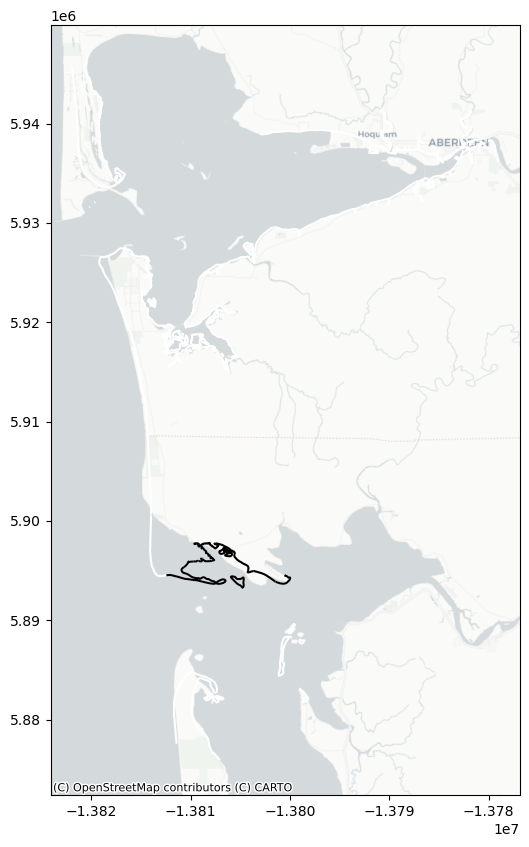

In [61]:
#plot clipped 1911 shoreline with function we defined
line_show(clipped_1911)

In [67]:
#create a new geodataframe for the clipped 1911 shoreline
#clipped_1911_gdf=gpd.GeoDataFrame(clipped_1911,crs=gdf_dict["shoreline_1911"].crs)
#not_clipped_1911
not_clipped_1911_gdf=gpd.GeoDataFrame({'geometry':not_clipped_1911},crs="epsg:4326")
not_clipped_1911_gdf

,geometry
0,"MULTILINESTRING ((-124.02782 46.90018, -124.02..."
1,"MULTILINESTRING ((-124.02703 46.90027, -124.02..."
2,"MULTILINESTRING ((-124.02668 46.90046, -124.02..."
3,"MULTILINESTRING ((-124.00882 46.91098, -124.00..."
4,"MULTILINESTRING ((-124.16458 47.02184, -124.16..."
...,...
704,LINESTRING Z EMPTY
705,LINESTRING Z EMPTY
706,"MULTILINESTRING ((-123.97364 46.66091, -123.97..."
707,"MULTILINESTRING ((-123.95227 46.62869, -123.95..."


In [70]:
clipped_1911_gdf=clipped_1911

In [73]:
pd.concat([clipped_1911_gdf,not_clipped_1911_gdf],ignore_index=True)

,FEATURE_ID,FEATURE,SOURCE_ID,DATA_SOURC,SRC_DATE,HOR_ACC,INFORM,RESOLUTION,ATTRIBUTE,CLASS,F_CODE,EX_METH,EXTRACT_TE,layer,geometry
0,950614.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.03416 46.70315, -124.03416 46..."
1,949599.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.01947 46.70556, -124.01969 46..."
2,949594.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.03416 46.70323, -124.03415 46..."
3,950617.0,26.0,T03224,P,19110101,0,None,0.0,Undetermined.Approximate,SHORELINE,None,M,P,layer1,"LINESTRING (-124.00076 46.71047, -124.00009 46..."
4,949589.0,20.0,T03224,P,19110101,0,None,0.0,Natural.Mean High Water,SHORELINE,None,M,P,layer1,"LINESTRING (-124.01754 46.72099, -124.01760 46..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINESTRING Z EMPTY
745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LINESTRING Z EMPTY
746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-123.97364 46.66091, -123.97..."
747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-123.95227 46.62869, -123.95..."


In [99]:
#function get the intersection point of a logitudal line and a geodataframe
def lon_intersection_gdf(gdf,point):
    line = LineString([(point[0], 46.657113), (point[0], point[1])])
    intersection_point = gdf["geometry"].intersection(line)
    non_empty_intersections = intersection_point[~intersection_point.is_empty]
    return non_empty_intersections

lon_intersection_gdf(gdf_dict["shoreline_1911"],find_south_point(coast_1700))


677    POINT (-124.07924 46.70784)
dtype: geometry

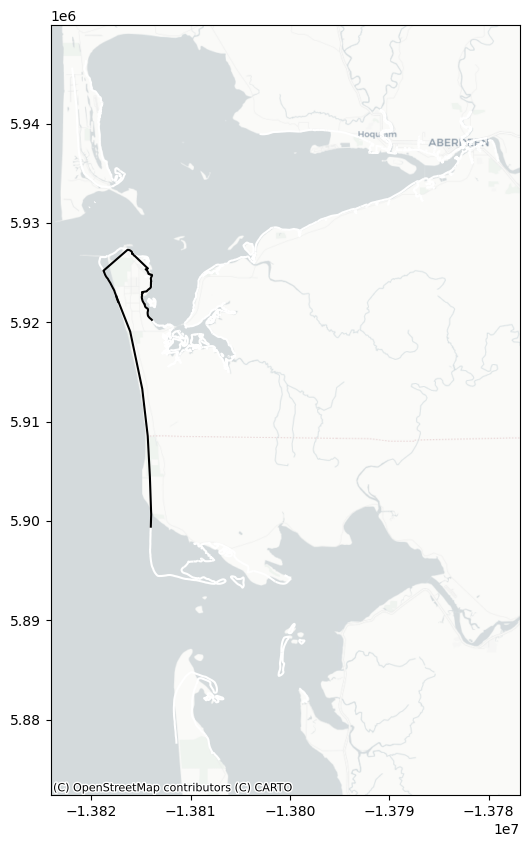

In [77]:
line_show(gdf_dict["shoreline_1910"])

In [130]:
gdf_dict["shoreline_1860"]

,Shape_Leng,layer,geometry
0,0.181588,layer1,"MULTILINESTRING ((-124.11763 46.87711, -124.11..."
1,NaN,layer2,"LINESTRING (-124.11763 46.87711, -124.11250 46..."


In [131]:
dir = "../assets/ECY_estimated_shorelines/Oct1/"
if not os.path.exists(dir):
    os.makedirs(dir)


for year in range(1700,1912):
    #print(year)
    #get the southernmost point of the shoreline each year
    south_point=find_south_point(gdf_dict[f"shoreline_{year}"])
    #get the longitude of the southernmost point
    south_lon=south_point[0]
    #get the intersection point of the longitude line and the shoreline of 1911
    intersection_point=lon_intersection_gdf(gdf_dict["shoreline_1911"],south_point).iloc[0]
    #get the gdf of the line from south point to the intersection point
    #print(intersection_point)
    #print(south_point)
    line=LineString([south_point,intersection_point])
    gdf_line=gpd.GeoDataFrame({'geometry':[line],'layer':'uncertainty-highest'},crs="EPSG:4326")
    
    #get the clip boundary
    lon_up_left=south_lon
    polygon_list=[(lon_up_left,lat_up_left),(lon_down_right,lat_up_left),(lon_down_right,lat_down_right),(lon_up_left,lat_down_right)]
    gdf_clip=clip(polygon_list,gdf_dict["shoreline_1911"])

    gdf_clip['layer']='uncertainty-highest'      #I set uncertainty level to be highest because I am simply using position of 1911 shoreline to be the position of the shoreline in years before 1911

    gdf_final=pd.concat([gdf_dict[f"shoreline_{year}"],gdf_line,gdf_clip],ignore_index=True)
    
    


    #output the gdf to geojson
    gdf_final.to_file(f"../assets/ECY_estimated_shorelines/Oct1/{year}.geojson", driver='GeoJSON') 
    
    #get the longitude of the 

    #gdf_dict[f"shoreline_{year}_clipped"]=clip(poly_list_1911,gdf_dict[f"shoreline_{year}"])

/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/usr/local/Caskroom/miniconda/base/envs/geo/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new ar

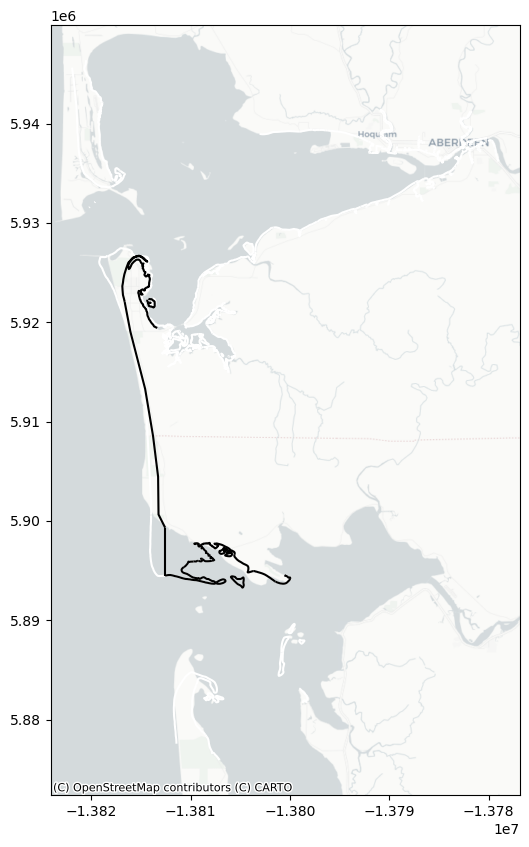

In [126]:
show=gpd.read_file(f"../assets/ECY_estimated_shorelines/Oct1/1801.geojson")
line_show(show)

In [ ]:
polygon=Polygon([(-124.10358, 46.733252766225945),(-124.08, 46.733252766225945),(-124.08,46.712),(-124.0345,46.712),(-124.0345,46.69),(-124.10358,46.69)])
gdf_1911_clipped = gdf_1911.clip(polygon)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=gdf_1911.crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf_1911_clipped.plot(ax=ax, color="purple")
poly_gdf.boundary.plot(ax=ax, color="black")